This files contains an example of tuning a Random Forest model with BayesSearchCV.

In [147]:
import pickle
import time

import helpsk as hlp
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

import plotly.io as pio
pio.renderers.default='notebook'

# Load Data

In [52]:
with open('../X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)

with open('../y_train.pkl', 'rb') as handle:
    y_train = pickle.load(handle)

In [53]:
hlp.pandas.numeric_summary(X_train, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
duration,760,40,5.0%,0,0.0%,21.0,11.7,0.6,1.0,0.6,4.0,9.0,12.0,18.0,24.0,36.0,60.0
credit_amount,800,0,0.0%,38,5.0%,"3,203.9","2,932.3",0.9,1.9,3.9,0.0,753.9,"1,300.8","2,236.5","3,951.5","7,394.6","18,424.0"
installment_commitment,800,0,0.0%,0,0.0%,3.0,1.1,0.4,-0.5,-1.2,1.0,1.0,2.0,3.0,4.0,4.0,4.0
residence_since,800,0,0.0%,0,0.0%,2.9,1.1,0.4,-0.3,-1.4,1.0,1.0,2.0,3.0,4.0,4.0,4.0
age,800,0,0.0%,0,0.0%,35.6,11.4,0.3,1.0,0.7,19.0,23.0,27.0,33.0,42.0,52.0,75.0
existing_credits,800,0,0.0%,0,0.0%,1.4,0.6,0.4,1.3,1.6,1.0,1.0,1.0,1.0,2.0,2.0,4.0
num_dependents,800,0,0.0%,0,0.0%,1.1,0.3,0.3,2.0,2.1,1.0,1.0,1.0,1.0,1.0,2.0,2.0


In [54]:
hlp.pandas.non_numeric_summary(X_train, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
checking_status,763,37,4.6%,no checking,4,0.5%
credit_history,800,0,0.0%,existing paid,5,0.6%
purpose,800,0,0.0%,radio/tv,10,1.2%
savings_status,800,0,0.0%,<100,5,0.6%
employment,800,0,0.0%,1<=X<4,5,0.6%
personal_status,800,0,0.0%,male single,4,0.5%
other_parties,800,0,0.0%,none,3,0.4%
property_magnitude,800,0,0.0%,car,4,0.5%
other_payment_plans,800,0,0.0%,none,3,0.4%
housing,800,0,0.0%,own,3,0.4%


In [55]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [56]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([241, 559]))

In [57]:
np.unique(y_train, return_counts=True)[1] / np.sum(np.unique(y_train, return_counts=True)[1])

array([0.30125, 0.69875])

# Transformation Pipeline

In [58]:
from sklearn.preprocessing import OrdinalEncoder
OrdinalEncoder().fit_transform(X_train[['purpose', 'savings_status']])

array([[0., 2.],
       [2., 2.],
       [9., 1.],
       ...,
       [9., 3.],
       [6., 4.],
       [6., 2.]])

In [59]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

logistic_estimator = make_pipeline(
    ColumnTransformer([
        (
            'numeric',
            make_pipeline(
                SimpleImputer(strategy='mean'),
#                 StandardScaler()
            ),
            numeric_columns
        ),
        (
            'non_numeric',
            make_pipeline(OneHotEncoder()),
            non_numeric_columns
        )
    ]),
    LogisticRegression(
        C=0.21380623392192172,
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
)

rf_estimator = make_pipeline(
    ColumnTransformer([
        (
            'numeric',
            make_pipeline(
                SimpleImputer(strategy='mean'),
                #StandardScaler()
            ),
            numeric_columns
        ),
        (
            'non_numeric',
            make_pipeline(hlp.sklearn_pipeline.CustomOrdinalEncoder()),
            non_numeric_columns
        )
    ]),
    RandomForestClassifier(
        max_features=0.001,
        n_estimators=2186,
        random_state=42,
    )
)


xgb_estimator = make_pipeline(
    ColumnTransformer([
        (
            'numeric',
            make_pipeline(
                SimpleImputer(strategy='mean'),
                StandardScaler()
            ),
            numeric_columns
        ),
        (
            'non_numeric',
            make_pipeline(hlp.sklearn_pipeline.CustomOrdinalEncoder()),
            non_numeric_columns
        )
    ]),
    XGBClassifier(
        colsample_bytree=0.1049484964611341,
        learning_rate=0.013882012240590661,
        max_depth=5,
        n_estimators=843,
        subsample=0.8790046279648855,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
)

estimators = [
    ('logistic', logistic_estimator),
    ('rf', rf_estimator),
    ('xgb', xgb_estimator),
]

# Model

`XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded on Apple Silicon (ARM)`

https://github.com/dmlc/xgboost/issues/6909

```
pip install --upgrade --force-reinstall xgboost --no-binary xgboost -v
```

In [62]:
from sklearn.ensemble import StackingClassifier

final_estimator = XGBClassifier(random_state=42,
                                eval_metric='logloss',
                                use_label_encoder=False)

stacking_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

# skopt.BayesSearchCV

[https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

In [68]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score  # , roc_auc_score
from sklearn.metrics import SCORERS

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# https://stackoverflow.com/questions/60615281/different-result-roc-auc-score-and-plot-roc-curve
scores = {
    # https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/metrics/_scorer.py#L537
    'ROC/AUC':  SCORERS['roc_auc'],
    'F1': make_scorer(f1_score, greater_is_better=True),
    'Pos. Pred. Val': make_scorer(precision_score, greater_is_better=True),
    'True Pos. Rate': make_scorer(recall_score, greater_is_better=True),
}

In [69]:
num_folds = 5
num_repeats = 2

In [70]:
# pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedKFold

https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

> max_depth: 3–10
> n_estimators: 100 (lots of observations) to 1000 (few observations)
> learning_rate: 0.01–0.3
> colsample_bytree: 0.5–1
> subsample: 0.6–1

> Then, you can focus on optimizing max_depth and n_estimators.
You can then play along with the learning_rate, and increase it to speed up the model without decreasing the performances. If it becomes faster without losing in performances, you can increase the number of estimators to try to increase the performances.

Find tuning options with:

```
bayes_search.get_params().keys()
```

Note that the param will be e.g. `final_estimator__max_depth` even though `bayes_search.get_params().keys()` returns `estimator__final_estimator__max_depth`

In [89]:
search_space = {
    'final_estimator__max_depth': Integer(3, 10),
    'final_estimator__n_estimators':  Integer(50, 2000),
    'final_estimator__learning_rate': Real(0.01, 0.3),
    'final_estimator__colsample_bytree': Real(0.01, 1),
    'final_estimator__subsample': Real(0.5, 1),
}

bayes_search = BayesSearchCV(
    estimator=stacking_model,
    search_spaces=search_space,
    n_iter=50,
    cv=RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats),
    scoring='roc_auc',
    # return_train_score=True,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

start_time = time.time()
bayes_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

del search_space

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

/Users/shanekercheval/opt/anaconda3/envs/python-examples/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[09:35:24] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:00] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:14] WARNING: /private/var/folders/7x/wc3jx_91337bgg

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[09:35:24] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:35:37] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explic

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[09:50:59] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:51:13] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explic

[09:35:23] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:00] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:38] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost

[09:35:23] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:00] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:39] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost

[09:51:00] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:51:37] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:52:13] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost

[09:35:24] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:00] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:14] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[09:35:24] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:00] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:39] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a44

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[09:35:23] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:35:37] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:36:00] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a44

[10:15:57] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [90]:
# find tuning options with:
# bayes_search.get_params().keys()

In [91]:
print(f"Elapsed time to run BayesSearchCV: {elapsed_time:.3f} seconds; {elapsed_time / 60:.1f} minutes")

Elapsed time to run BayesSearchCV: 2457.124 seconds; 41.0 minutes


In [92]:
print(bayes_search.cv_results_)

{'mean_fit_time': array([ 20.03319309,  20.93146067,  21.42498319,  20.58584046,
        19.74722571,  19.61807442,  19.56236939,  19.7136481 ,
        19.51024511,  19.27614281,  19.60251358,  19.03326991,
        21.36033602,  20.0858618 ,  19.86024106,  19.48744135,
        19.69230492,  19.28768649,  22.24191105,  20.25518696,
        21.80150721,  19.07263029,  23.04028518,  21.5916615 ,
        20.42062399,  20.22293112,  20.59804492,  20.8699692 ,
        20.53545721,  20.95954723,  21.28266323,  20.30639374,
        20.31211922,  19.92081215,  19.46460001,  19.55028403,
        19.67123961,  20.44993873,  21.5477098 ,  19.99522483,
        19.9798476 ,  19.71725888,  19.63753879,  19.49015882,
        19.64706333,  19.57934246,  20.00771263, 149.55569654,
        19.95022449,  18.78917754]), 'std_fit_time': array([  3.44374786,   3.65865291,   4.20242961,   3.64434541,
         3.39225822,   3.39230186,   3.33459211,   3.35692512,
         3.29990376,   3.3325283 ,   3.33887692

In [93]:
print(bayes_search.best_score_)

0.7787674545779986


In [94]:
print(bayes_search.best_params_)

OrderedDict([('final_estimator__colsample_bytree', 0.01), ('final_estimator__learning_rate', 0.06159811010986713), ('final_estimator__max_depth', 3), ('final_estimator__n_estimators', 50), ('final_estimator__subsample', 0.5)])


# Results

In [107]:
new_param_column_names = {
    'final_estimator__max_depth': 'max_depth',
    'final_estimator__n_estimators': 'n_estimators',
    'final_estimator__learning_rate': 'learning_rate',
    'final_estimator__colsample_bytree': 'colsample_bytree',
    'final_estimator__subsample': 'subsample',
}

In [108]:
parser = hlp.sklearn_eval.SearchCVParser(searcher=bayes_search,
                                         higher_score_is_better = True,
                                         parameter_name_mappings = new_param_column_names)

In [109]:
parser.to_yaml_file(yaml_file_name = 'Run 1 - Stacking - BayesSearchCV.yaml')

In [110]:
parser = hlp.sklearn_eval.SearchCVParser.from_yaml_file(yaml_file_name = 'Run 1 - Stacking - BayesSearchCV.yaml')

## Timings

In [111]:
parser.fit_time_averages

array([ 20.03319309,  20.93146067,  21.42498319,  20.58584046,
        19.74722571,  19.61807442,  19.56236939,  19.7136481 ,
        19.51024511,  19.27614281,  19.60251358,  19.03326991,
        21.36033602,  20.0858618 ,  19.86024106,  19.48744135,
        19.69230492,  19.28768649,  22.24191105,  20.25518696,
        21.80150721,  19.07263029,  23.04028518,  21.5916615 ,
        20.42062399,  20.22293112,  20.59804492,  20.8699692 ,
        20.53545721,  20.95954723,  21.28266323,  20.30639374,
        20.31211922,  19.92081215,  19.46460001,  19.55028403,
        19.67123961,  20.44993873,  21.5477098 ,  19.99522483,
        19.9798476 ,  19.71725888,  19.63753879,  19.49015882,
        19.64706333,  19.57934246,  20.00771263, 149.55569654,
        19.95022449,  18.78917754])

## Best Scores/Params

In [112]:
parser.best_primary_score

0.7787674545779986

In [113]:
parser.best_primary_score_params

{'colsample_bytree': 0.01,
 'learning_rate': 0.06159811010986713,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 0.5}

In [114]:
parser.to_formatted_dataframe()

roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,colsample_bytree,learning_rate,max_depth,n_estimators,subsample
0.779,0.760,0.797,0.010,0.062,3,50,0.500
0.774,0.758,0.790,0.010,0.076,3,50,0.771
0.774,0.750,0.797,0.010,0.010,3,50,0.500
0.773,0.742,0.805,0.953,0.040,3,57,0.746
0.773,0.761,0.785,0.463,0.010,3,50,0.599
0.772,0.752,0.792,0.225,0.014,10,63,0.739
0.770,0.747,0.793,0.027,0.044,3,60,0.760
0.770,0.746,0.794,1.000,0.072,3,50,0.500
0.770,0.748,0.792,1.000,0.101,3,50,0.989
0.769,0.748,0.790,0.793,0.010,3,50,0.500


In [115]:
# gives the score rank for each index
# e.g. array([4, 2, 1, 3)
# the 1st iteration (i.e. set of params) was the worst
# the 3rd iteration was the best.
parser.primary_score_iteration_ranking

array([47, 45, 50, 38, 42, 43, 46, 48, 40, 49, 36, 15, 10, 11, 16, 33, 28,
        3, 41, 22, 12,  9,  8, 13, 14,  2, 32, 34, 20,  4, 17, 26, 19, 30,
        5, 21, 25, 35,  7,  6, 29, 23, 37, 24,  1, 27, 44, 39, 31, 18])

In [116]:
# gives the 
# e.g. parser.primary_score_iteration_ranking of array([4, 2, 1, 3)
# would return [2, 1, 4, 0] because index 2 (i.e. 3rd iteration) was the best, so it is the first index;
# and index 0 (i.e. first iteration) was the was
parser.primary_score_best_indexes

array([44, 25, 17, 29, 34, 39, 38, 22, 21, 12, 13, 20, 23, 24, 11, 14, 30,
       49, 32, 28, 35, 19, 41, 43, 36, 31, 45, 16, 40, 33, 48, 26, 15, 27,
       37, 10, 42,  3, 47,  8, 18,  4,  5, 46,  1,  6,  0,  7,  9,  2])

In [117]:
score_df = parser.to_dataframe(sort_by_score=False)
columns = score_df.columns.to_list()  # cache columns to move Iteration column to front
score_df['Iteration'] = np.arange(1, parser.number_of_iterations + 1)
score_df = score_df[['Iteration'] + columns]
# create the labels that will be used in the plotly hover text
score_df['labels'] = [x.replace('{', '<br>').replace(', ', '<br>').replace('}', '')
                      for x in parser.iteration_labels(order_from_best_to_worst=False)]
del columns

score_variable = parser.primary_score_name + " Mean"

In [118]:
score_df.head(1)

,Iteration,roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,labels
0,1,0.667213,0.644471,0.689954,0.416003,0.22104,10,666,0.835074,<br>colsample_bytree: 0.4160029192647807<br>le...


## BayesSearchCV Performance Over Time

In [120]:
size_variable = 'learning_rate'
color_variable = 'colsample_bytree'
fig = px.scatter(
    data_frame=score_df,
    x='Iteration',
    y=score_variable,
    size=size_variable,
    color=color_variable,
    trendline='lowess',
    labels={
        score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
    },
    title=f"Bayesian Performance Over Time<br>" \
          f"<sup>Size of point corresponds to '{size_variable}'</sup>",
    custom_data=['labels'],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
fig.update_traces(
    hovertemplate="<br>".join([
        "Iteration: %{x}",
        score_variable + ": " + "%{y}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
fig.show()

del size_variable
del color_variable

---

## Variable Performance Over Time

In [121]:
score_df_long_numeric = pd.melt(score_df,
                                id_vars=['Iteration', score_variable, 'labels'],
                                value_vars=parser.numeric_parameters)
#score_df_long_numeric.head(1)

In [122]:
color_variable = score_variable
fig = px.scatter(
    data_frame=score_df_long_numeric,
    x='Iteration',
    y='value',
    color=color_variable,
    facet_col='variable',
    trendline='lowess',
    labels={
        'value': 'Parameter Value',
    },
    title="Variable Performance Over Time",
    custom_data=['labels', score_variable],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
fig.update_traces(
    hovertemplate="<br>".join([
        "Iteration: %{x}",
        "Parameter Value: %{y}",
        "roc_auc Mean: %{customdata[1]}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

del color_variable

---

## Variable Performance - Numeric

In [131]:
color_variable = score_variable
fig = px.scatter(
    data_frame=score_df_long_numeric,
    x='value',
    y=score_variable,
    color=color_variable,
    facet_col='variable',
    facet_col_wrap=2,
    trendline='lowess',
    labels={
#        score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
        'value': 'Parameter Value',
    },
    title="Variable Performance<br><sup>Numeric Parameters</sup>",
    custom_data=['labels', score_variable],
    height=1000,
    width=1000*hlp.plot.GOLDEN_RATIO
)
fig.update_traces(
    hovertemplate="<br>".join([
        "Parameter Value: %{x}",
        "roc_auc Mean: %{customdata[1]}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
fig.update_xaxes(matches=None, showticklabels=True)
#fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

del color_variable

---

## Variable Performance - Non-Numeric

In [148]:
score_df_long_non_numeric = pd.melt(score_df,
                                    id_vars=['Iteration', score_variable, 'labels'],
                                    value_vars=parser.non_numeric_parameters)
score_df_long_numeric.head(1)

,Iteration,roc_auc Mean,labels,variable,value
0,1,0.667213,<br>colsample_bytree: 0.4160029192647807<br>le...,colsample_bytree,0.416003


In [174]:
color_variable = score_variable
scatter = px.scatter(
    data_frame=score_df_long_non_numeric,
    x='value',
    y=score_variable,
    color=color_variable,
    facet_col='variable',
    facet_col_wrap=2,
    #trendline='lowess',
    labels={
#        score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
        'value': 'Parameter Value',
    },
    title="Variable Performance<br><sup>Non-Numeric Parameters</sup>",
    custom_data=['labels', score_variable],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
scatter.update_traces(
    hovertemplate="<br>".join([
        "Parameter Value: %{x}",
        "roc_auc Mean: %{customdata[1]}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
scatter.update_xaxes(matches=None, showticklabels=True)
#scatter.show()

del color_variable

UnboundLocalError: local variable 'fig' referenced before assignment

In [175]:
color_variable = score_variable
fig = px.box(
    data_frame=score_df_long_non_numeric,
    x='value',
    y=score_variable,
#    color=color_variable,
    facet_col='variable',
    facet_col_wrap=2,
    #trendline='lowess',
    labels={
#        score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
        'value': 'Parameter Value',
    },
    title="Variable Performance<br><sup>Non-Numeric Parameters</sup>",
    custom_data=['labels', score_variable],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
for x in range(len(scatter.data)):
    fig.add_trace(scatter.data[x])

fig.update_xaxes(matches=None, showticklabels=True)
fig.show()

del color_variable

UnboundLocalError: local variable 'fig' referenced before assignment

## Individual Variable Performance

---

In [155]:
x_variable = 'learning_rate'
size_variable = 'colsample_bytree'
#color_variable = 'scaler'
fig = px.scatter(
    data_frame=score_df,
    x=x_variable,
    y=score_variable,
    size=size_variable,
#    color=color_variable,
    trendline='lowess',
    labels={
        score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
    },
    title=f"<b>{x_variable}</b> - Performance<br>" \
          f"<sup>Size of point corresponds to '{size_variable}'</sup>",
    custom_data=['labels'],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
fig.update_traces(
    hovertemplate="<br>".join([
        "Parameter Value: %{x}",
        score_variable + ": " + "%{y}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
fig.show()

del x_variable
del size_variable
#del color_variable

In [152]:
size_variable = score_variable

from sklearn.preprocessing import MinMaxScaler
scaled_size = MinMaxScaler().fit_transform(score_df[[size_variable]]).reshape(1, -1)
scaled_size = scaled_size.tolist()[0]

x_variable = 'learning_rate'
y_variable = 'colsample_bytree'

color_variable = score_variable
fig = px.scatter(
    data_frame=score_df,
    x=x_variable,
    y=y_variable,
#    size=score_df[size_variable],
    size=scaled_size,
    color=color_variable,
    trendline='lowess',
#     labels={
#         score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
#     },
    title=f"Performance of <b>{x_variable}</b> vs <b>{y_variable}</b><br>" \
          f"<sup>color and size corresponds to `{score_variable}`</sup>",
    custom_data=['labels', score_variable],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
fig.update_traces(
    hovertemplate="<br>".join([
        x_variable + ": %{x}",
        y_variable + ": %{y}",
        score_variable + ": " + "%{customdata[1]}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
fig.show()

del x_variable
del size_variable
del scaled_size
del color_variable

---

# Regression on `roc_auc Mean`

In [156]:
score_variable

'roc_auc Mean'

In [157]:
score_dataframe = parser.to_dataframe()
score_dataframe = score_dataframe.drop(columns=[x for x in score_dataframe.columns
                              if x not in [score_variable] + parser.parameter_names])
score_dataframe.head()

,roc_auc Mean,colsample_bytree,learning_rate,max_depth,n_estimators,subsample
44,0.778767,0.01000,0.061598,3,50,0.500000
25,0.773784,0.01000,0.076356,3,50,0.771228
17,0.773725,0.01000,0.010000,3,50,0.500000
29,0.773214,0.95346,0.039607,3,57,0.746057
34,0.772716,0.46319,0.010000,3,50,0.598641


In [158]:
cleaned_column_names = [''.join(e for e in x.replace(' ', '_') if e == '_' or e.isalnum()) for x in score_dataframe.columns.tolist()]
cleaned_column_names = dict(zip(score_dataframe.columns.tolist(), cleaned_column_names))
cleaned_column_names

{'roc_auc Mean': 'roc_auc_Mean',
 'colsample_bytree': 'colsample_bytree',
 'learning_rate': 'learning_rate',
 'max_depth': 'max_depth',
 'n_estimators': 'n_estimators',
 'subsample': 'subsample'}

In [159]:
score_dataframe = score_dataframe.rename(columns=cleaned_column_names)

In [160]:
import statsmodels.formula.api as smf

y_column = 'roc_auc_Mean'
X_columns = score_dataframe.columns.tolist()
X_columns.remove(y_column)
X_columns = hlp.string.collapse(X_columns, separate=" + ", surround="")

formula = f"{y_column} ~ {X_columns}"
print(formula)
model = smf.ols(formula=formula, data = score_dataframe)
results = model.fit()
print(results.summary())

roc_auc_Mean ~ colsample_bytree + learning_rate + max_depth + n_estimators + subsample
                            OLS Regression Results                            
Dep. Variable:           roc_auc_Mean   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     70.50
Date:                Wed, 29 Dec 2021   Prob (F-statistic):           7.04e-20
Time:                        10:33:05   Log-Likelihood:                 149.90
No. Observations:                  50   AIC:                            -287.8
Df Residuals:                      44   BIC:                            -276.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [161]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd

scaler = StandardScaler()
#scaler.fit_transform(bayes_search_df)

numeric_columns = hlp.pandas.get_numeric_columns(score_dataframe)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(score_dataframe)

print(numeric_columns)
print(non_numeric_columns)

numeric_pipeline = Pipeline([
    ('scaling', StandardScaler()),
])

transformations_pipeline = ColumnTransformer([
    ('numeric_pipeline', numeric_pipeline, numeric_columns),
    ('non_numeric_pipeline', 'passthrough', non_numeric_columns)
])

score_dataframe_transformed = transformations_pipeline.fit_transform(score_dataframe)
score_dataframe_transformed = pd.DataFrame(score_dataframe_transformed,
                                           columns= numeric_columns + non_numeric_columns)
score_dataframe_transformed.head()

['roc_auc_Mean', 'colsample_bytree', 'learning_rate', 'max_depth', 'n_estimators', 'subsample']
[]


,roc_auc_Mean,colsample_bytree,learning_rate,max_depth,n_estimators,subsample
0,1.116311,-1.188918,-0.222231,-0.77471,-0.633033,-1.288244
1,0.978777,-1.188918,-0.058760,-0.77471,-0.633033,0.191249
2,0.977130,-1.188918,-0.793777,-0.77471,-0.633033,-1.288244
3,0.963036,1.165690,-0.465824,-0.77471,-0.622118,0.053945
4,0.949286,-0.057886,-0.793777,-0.77471,-0.633033,-0.750178


In [162]:
score_dataframe_transformed['roc_auc_Mean'] = score_dataframe_transformed['roc_auc_Mean'].astype('float')
score_dataframe_transformed['colsample_bytree'] = score_dataframe_transformed['colsample_bytree'].astype('float')
score_dataframe_transformed['learning_rate'] = score_dataframe_transformed['learning_rate'].astype('float')
score_dataframe_transformed['max_depth'] = score_dataframe_transformed['max_depth'].astype('float')
score_dataframe_transformed['n_estimators'] = score_dataframe_transformed['n_estimators'].astype('float')
score_dataframe_transformed['subsample'] = score_dataframe_transformed['subsample'].astype('float')

In [163]:
print(formula)
model = smf.ols(formula=formula,
                data = score_dataframe_transformed)
results = model.fit()
print(results.summary())

roc_auc_Mean ~ colsample_bytree + learning_rate + max_depth + n_estimators + subsample
                            OLS Regression Results                            
Dep. Variable:           roc_auc_Mean   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     70.50
Date:                Wed, 29 Dec 2021   Prob (F-statistic):           7.04e-20
Time:                        10:33:06   Log-Likelihood:                -15.985
No. Observations:                  50   AIC:                             43.97
Df Residuals:                      44   BIC:                             55.44
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [164]:
coefficients = pd.DataFrame({
    'feature': results.params.index,
    'coefficient': results.params,
    'p_value': results.pvalues,
})
coefficients = coefficients.query("feature != 'Intercept'")
coefficients['Stat Sig'] = coefficients['p_value'] <= 0.05
coefficients

,feature,coefficient,p_value,Stat Sig
colsample_bytree,colsample_bytree,0.033975,5.133456e-01,False
learning_rate,learning_rate,-0.600380,8.506239e-14,True
max_depth,max_depth,-0.197165,4.076191e-04,True
n_estimators,n_estimators,-0.461345,1.347250e-10,True
subsample,subsample,-0.000153,9.976384e-01,False


In [165]:
score_variable

'roc_auc Mean'

In [166]:
px.bar(
    data_frame=coefficients.reindex(coefficients['coefficient'].abs().sort_values(ascending=True).index),
    y='feature',
    x='coefficient',
    color='Stat Sig',
    title=f"Regression Coefficients of Hyper-parameters against '{score_variable}'",
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)

# Feature Importance

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [167]:
from sklearn.inspection import permutation_importance

estimator = bayes_search.best_estimator_

start_time = time.time()
result = permutation_importance(
    estimator, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

feature_names = X_train.columns.to_list()
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

Elapsed time to compute the importances: 39.119 seconds


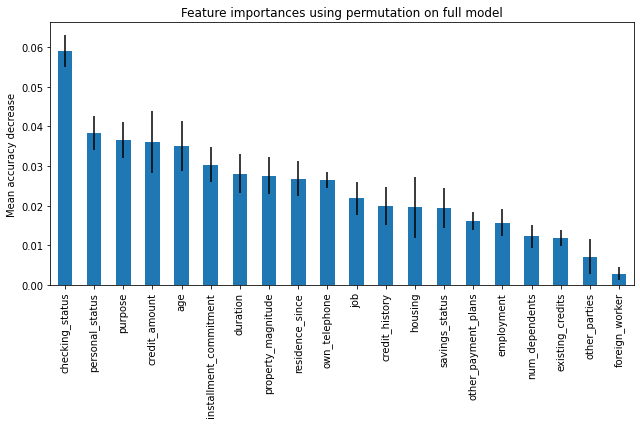

In [168]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.set_size_inches(9, 6)
fig.tight_layout()
plt.show()

In [169]:
temp = X_train.copy()
temp['default'] = y_train
temp.groupby('foreign_worker').agg({'default': np.mean})

,default
foreign_worker,
yes,0.691710
no,0.892857


In [170]:
fig = px.box(
    data_frame=temp,
    y='age',
    x='default',
#    size=size_variable,
#    color=color_variable,
#    trendline='lowess',
#     labels={
#         score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
#     },
#     title=f"<b>{x_variable}</b> - Performance<br>" \
#           f"<sup>Size of point corresponds to '{size_variable}'</sup>",
#     custom_data=['labels'],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
fig.show()

NOTE: foreign worker seems like it should be important but is ranked last in feature importance.